In [1]:
import pandas as pd
import numpy as np
import wrangle
import explore

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from scipy import stats
from math import sqrt

import sklearn.preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression, SelectKBest, RFE

## Wrangle My Data:
- Acquire my dataframe
- Prepare/Clean my Dataframe
- Complete initial exploration to verify.

In [2]:
# acquire my dataframe from sql
df = wrangle.get_zillow()

In [3]:
# first address white spaces
df = df.replace(r'^\s*$', np.nan, regex=True)

In [4]:
# use my info function to find out more information
wrangle.get_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38396 entries, 0 to 38395
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    38396 non-null  float64
 1   bathroomcnt                   38396 non-null  float64
 2   calculatedfinishedsquarefeet  38288 non-null  float64
 3   taxvaluedollarcnt             38395 non-null  float64
 4   yearbuilt                     38264 non-null  float64
 5   taxamount                     38395 non-null  float64
 6   fips                          38396 non-null  float64
 7   parcelid                      38396 non-null  int64  
dtypes: float64(7), int64(1)
memory usage: 2.3 MB
None
------------------------
------------------------
This dataframe has 38396 rows and 8 columns.
------------------------
Null count in dataframe:
------------------------
bedroomcnt                        0
bathroomcnt                       0
calcu

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips,parcelid
26069,3.0,2.0,1405.0,282181.0,1971.0,3460.86,6037.0,12813001
36835,2.0,2.5,1877.0,883000.0,2005.0,9950.32,6059.0,14706711
10101,4.0,2.0,2064.0,644943.0,1964.0,7528.65,6037.0,13078992


In [5]:
# let's rename our columns so they are more clear
df.rename(columns={'bedroomcnt': 'num_bedroom', 
                     'bathroomcnt': 'num_bathroom',
                     'calculatedfinishedsquarefeet': 'finished_sqft',
                     'taxvaluedollarcnt': 'tax_value',
                     'yearbuilt': 'build_year',
                     'taxamount': 'property_tax'}, inplace=True)

In [6]:
# since the nulls only account for .003 of the dataframe, let's drop nulls
df.dropna(inplace=True)
print(df.isnull().sum())
df.shape

num_bedroom      0
num_bathroom     0
finished_sqft    0
tax_value        0
build_year       0
property_tax     0
fips             0
parcelid         0
dtype: int64


(38258, 8)

In [7]:
df.drop_duplicates(inplace=True)
df.shape

(38226, 8)

In [8]:
# Tells us unique count
df.nunique()

num_bedroom         13
num_bathroom        19
finished_sqft     4187
tax_value        28238
build_year         131
property_tax     37317
fips                 3
parcelid         38226
dtype: int64

In [9]:
# now that we've been able to drop any houses with duplicate parcel ids, we can drop the column
df.drop(columns='parcelid', inplace=True)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_bedroom,38226.0,3.022681,1.014806,0.00,2.00,3.00,4.0000,12.00
num_bathroom,38226.0,2.281745,0.943957,0.00,2.00,2.00,3.0000,11.00
finished_sqft,38226.0,1764.114582,927.452077,240.00,1174.00,1528.00,2085.0000,17245.00
tax_value,38226.0,496290.981348,629482.402761,1000.00,209401.50,364991.00,578708.5000,23858374.00
build_year,38226.0,1969.475749,23.102659,1878.00,1954.00,1970.00,1987.0000,2016.00
property_tax,38226.0,6041.119686,7319.556260,19.92,2728.97,4480.26,7001.7475,276797.83
fips,38226.0,6049.504630,20.922553,6037.00,6037.00,6037.00,6059.0000,6111.00


In [10]:
column = ['num_bedroom', 'num_bathroom', 'fips']
wrangle.value_counts(df, column)

num_bedroom
3.0     15503
2.0      9685
4.0      8680
5.0      2151
1.0      1659
6.0       338
0.0       143
7.0        50
8.0         8
9.0         4
10.0        2
11.0        2
12.0        1
Name: num_bedroom, dtype: int64
-------------
num_bathroom
2.0     15827
3.0      8286
1.0      6555
2.5      3606
4.0      1336
1.5       736
3.5       594
5.0       456
4.5       385
6.0       179
5.5       111
7.0        52
0.0        30
8.0        29
6.5        27
7.5         9
9.0         5
11.0        2
10.0        1
Name: num_bathroom, dtype: int64
-------------
fips
6037.0    23989
6059.0    11068
6111.0     3169
Name: fips, dtype: int64
-------------


In [18]:
df['fips'] = df['fips'].astype(str)
df.loc[df['fips'].str[0] == '6','State'] = 'California'
df.loc[df['fips'].str.contains('111'),'County'] = 'Ventura'
df.loc[df['fips'].str.contains('037'),'County'] = 'Los Angeles'
df.loc[df['fips'].str.contains('059'),'County'] = 'Orange'
df['fips'] = df['fips'].astype(float)
    
df['tax_rate'] = (df['property_tax']/df['tax_value'] * 100)

In [19]:
df.head()

,num_bedroom,num_bathroom,finished_sqft,tax_value,build_year,property_tax,fips,State,County,tax_rate
0,3.0,2.0,1125.0,289445.0,1974.0,3490.16,6059.0,California,Orange,1.205811
1,3.0,2.0,1316.0,205123.0,1923.0,2627.48,6037.0,California,Los Angeles,1.280929
2,3.0,2.0,1458.0,136104.0,1970.0,2319.90,6037.0,California,Los Angeles,1.704505
3,3.0,2.0,1766.0,810694.0,1980.0,9407.01,6037.0,California,Los Angeles,1.160365
4,2.0,1.0,1421.0,35606.0,1911.0,543.69,6037.0,California,Los Angeles,1.526962


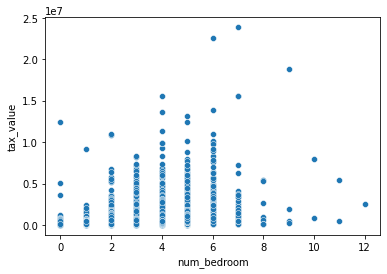

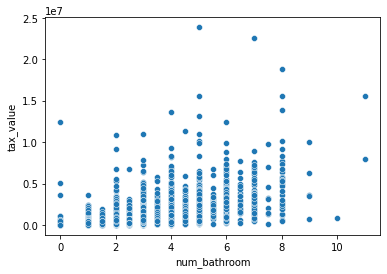

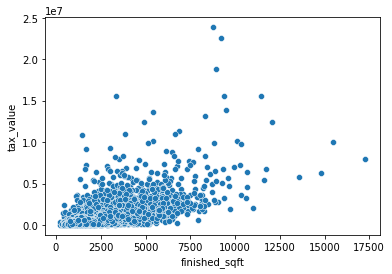

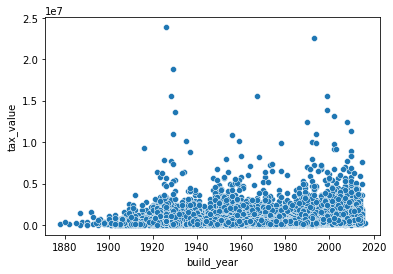

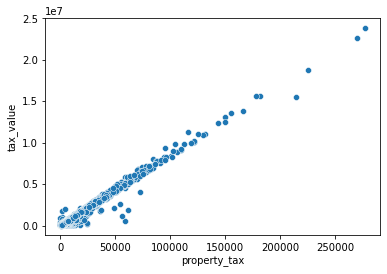

In [12]:
# visualize outliers
cols = df.drop(columns=['tax_value', 'fips'])
explore.scatterplot(cols, df.tax_value, df)

In [13]:
df.shape

(38226, 7)

In [14]:
# remove outliers
cols = df.drop(columns='fips')
df = wrangle.outlier_bounds(df, cols)
df.shape

For num_bedroom the lower bound is 0 and  upper bound is 7.0
For num_bathroom the lower bound is 0.5 and  upper bound is 4.5
For finished_sqft the lower bound is 0 and  upper bound is 3329.0
For tax_value the lower bound is 0 and  upper bound is 1031868.5
For build_year the lower bound is 1907.125 and  upper bound is 2016.0
For property_tax the lower bound is 0 and  upper bound is 11316.872500000001


(33636, 7)

In [16]:
# take a look at the dataframe with removed outliers
df.head(3)

,num_bedroom,num_bathroom,finished_sqft,tax_value,build_year,property_tax,fips
0,3.0,2.0,1125.0,289445.0,1974.0,3490.16,6059.0
1,3.0,2.0,1316.0,205123.0,1923.0,2627.48,6037.0
2,3.0,2.0,1458.0,136104.0,1970.0,2319.90,6037.0


In [17]:
# take a look at clean value counts
column = ['num_bedroom', 'num_bathroom', 'fips']
wrangle.value_counts(df, column)

num_bedroom
3.0    14380
2.0     9344
4.0     7034
1.0     1631
5.0     1116
6.0      116
7.0       15
Name: num_bedroom, dtype: int64
-------------
num_bathroom
2.0    15251
3.0     7112
1.0     6340
2.5     3433
1.5      731
4.0      502
3.5      235
4.5       32
Name: num_bathroom, dtype: int64
-------------
fips
6037.0    21101
6059.0     9676
6111.0     2859
Name: fips, dtype: int64
-------------


In [15]:
# To use when I want to concatenate my dfs back together
# df = pd.concat([x_train_scaled, y_train], axis=0)